In [94]:
import time
from itertools import product
import numpy as np
from scipy.stats import poisson, skellam
import matplotlib.pyplot as plt

maxNumCounted = 28
credit_rate = 10
transfer_price = 2
parking_price = 4
expectedRent1 = 3
expectedReturn1 = 3
expectedRent2 = 4
expectedReturn2 = 2
maxCarsAvail = 20
maxCarsTransferred = 5
states_num = (maxCarsAvail+1)*(maxCarsAvail+1)

In [95]:
def evalDetermPolicy_2(value, policy, getStatesIter, getStateTransitionsDist, gamma, max_iter=None, Theta=1.0e-5):
    it = 1
    startTime = time.time()
    while True:
        lap_time = time.time()
        delta = 0
        print("Iteration {}  ".format(it), end="", flush=True)
        for step, state in enumerate(getStatesIter()):
            action = policy[state]
            sum_reward, dist = getStateTransitionsDist(state,action)
            v = sum_reward + gamma*np.tensordot(dist,value)
            delta = max(delta, abs(v-value[state]))
            value[state] = v
            if time.time()-lap_time >= 10:
                print("\rIteration {}; Progress {:4.1f}%".format(it, float(step)/states_num*100), 
                      end="", flush=True)
                lap_time = time.time()
        print("\n[Done] in {:5.4} sec; delta={}".format(time.time()-startTime, delta))
        if max_iter and it >= max_iter or delta < Theta: break
        it += 1
    return value

def improvePolicy_2(value, policy, getStatesIter, getActionsIter, 
                  getStateTransitionsDist, gamma):
    policy_stable = True
    startTime = time.time()
    lap_time = startTime
    print("Improving policy.", end="", flush=True)
    for step,state in enumerate(getStatesIter()):
        old_action = policy[state]
        max_qsa = np.finfo(np.float32).min
        for action in getActionsIter(state):
            sum_reward, dist = getStateTransitionsDist(state,action)
            qsa = sum_reward + gamma*np.tensordot(dist,value)

            if qsa > max_qsa:
                max_qsa = qsa
                max_action = action

        policy[state] = max_action
        policy_stable = policy_stable and max_action == old_action
        if time.time()-lap_time >= 10:
            print("\rImproving policy. Progress {:4.1f}%".format(float(step)/states_num*100), 
                  end="", flush=True)
            lap_time = time.time()
        
    print("\n[Done in {:5.4} sec]".format(time.time()-startTime))
    return policy_stable

In [96]:
poissonCache = np.array([[poisson.pmf(x,expect)
                          for x in range(maxNumCounted+1)]
                         for expect in range(expectedReturn2,expectedRent2+1)],
                        dtype=np.float64)

def getPoisson(n,e):
    return poissonCache[e-expectedReturn2, n]

getActionsIter = \
    lambda s: range(max(-s[1],-maxCarsTransferred), min(s[0],maxCarsTransferred)+1)


In [97]:
# returns probability distribution and weighted reward of state transitions 
# in a single location. State transition is (available, transition) -> remained
def getJacksCarProbDist(available, transition, expectedRent, expectedReturn):
    dist = np.zeros(shape=(maxCarsAvail+1,2), dtype=np.float64)
    if transition > available:
        return dist

    for requested_for_rent,returned in product(range(maxNumCounted+1), repeat=2):
        available_for_rent = min(available-transition+returned, maxCarsAvail)
        actually_rented = min(available_for_rent, requested_for_rent)
        remained = available_for_rent - actually_rented
        
        prob = getPoisson(requested_for_rent, expectedRent) * \
                           getPoisson(returned, expectedReturn)
        dist[remained] += \
            [prob, 
             prob * (actually_rented*credit_rate - int(available>10)*parking_price)]

    return dist

getDistribution = getJacksCarProbDist # This distribution might be computed in a bit different way, but the result would be the same

jacks_car_distribution_1 = \
    [dict([(t,getDistribution(cars_left, t, expectedRent1, expectedReturn1)) 
     for t in range(-maxCarsTransferred, min(cars_left,maxCarsTransferred)+1)]) 
    for cars_left in range(maxCarsAvail+1)]

jacks_car_distribution_2 = \
    [dict([(t,getDistribution(cars_left, t, expectedRent2, expectedReturn2)) 
     for t in range(-maxCarsTransferred, min(cars_left,maxCarsTransferred)+1)]) 
    for cars_left in range(maxCarsAvail+1)]

zero_dist = (0.0, np.zeros(shape=(maxCarsAvail+1,maxCarsAvail+1,2)))

def getCachedDist(cars_left,transfer):
    dict_1 = jacks_car_distribution_1[cars_left[0]]
    if not transfer in dict_1:
        return zero_dist
    p_wr_1 = dict_1[transfer]
    dict_2 = jacks_car_distribution_2[cars_left[1]]
    if not -transfer in dict_2:
        return zero_dist
    p_wr_2 = dict_2[-transfer]
    
    transfer_cost = transfer_price*abs(transfer-int(transfer>0))
    w_reward = np.sum(p_wr_1[:,1]) + np.sum(p_wr_2[:,1]) - transfer_cost
    return (w_reward, 
        np.matmul(np.array([p_wr_1[:,0]]).transpose(), np.array([p_wr_2[:,0]]))
           )
    

### Compete Policy Iteration

In [98]:
value = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.float64)
policy = np.zeros((maxCarsAvail+1,maxCarsAvail+1), dtype=np.int8)
policy_iterations = []

while True:
    v = evalDetermPolicy_2(
               value,
               policy,
               lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
               getCachedDist, #getJacksCarTransitionsDist,
               max_iter=15,
               Theta=0.01
              )
    policy_iterations.append(policy.copy())
    
    if improvePolicy_2(
              value,
              policy,
              lambda : product(range(maxCarsAvail+1),range(maxCarsAvail+1)),
              getActionsIter,
              getCachedDist, #getJacksCarTransitionsDist,
              gamma=0.9
              ):
        break

Iteration 1  
[Done] in 0.03207 sec; delta=193.19995163681992
Iteration 2  
[Done] in 0.05826 sec; delta=112.49946992634958
Iteration 3  
[Done] in 0.08267 sec; delta=81.3365030876675
Iteration 4  
[Done] in 0.1075 sec; delta=59.11162329875276
Iteration 5  
[Done] in 0.1312 sec; delta=43.883943050515654
Iteration 6  
[Done] in 0.1556 sec; delta=34.09120310770797
Iteration 7  
[Done] in 0.1798 sec; delta=29.653240175564008
Iteration 8  
[Done] in 0.2045 sec; delta=25.620976995567673
Iteration 9  
[Done] in 0.229 sec; delta=22.03452057031251
Iteration 10  
[Done] in 0.2538 sec; delta=18.883038045367925
Iteration 11  
[Done] in 0.2784 sec; delta=16.134844705755597
Iteration 12  
[Done] in 0.3036 sec; delta=13.751397833244027
Iteration 13  
[Done] in 0.3288 sec; delta=11.693348473750916
Iteration 14  
[Done] in 0.353 sec; delta=9.922998293913906
Iteration 15  
[Done] in 0.3794 sec; delta=8.405260606025593
Improving policy.
[Done in 0.1444 sec]
Iteration 1  
[Done] in 0.0226 sec; delta=91.1

### Draw the value function

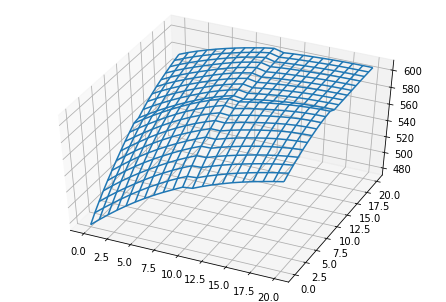

In [103]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

X = np.arange(0, 21, 1)
Y = np.arange(0, 21, 1)
X, Y = np.meshgrid(X, Y)

it = zip(X.ravel(), Y.ravel())

fig = plt.figure()
ax = Axes3D(fig, azim=-65, elev = 45)
#ax.plot_surface(X, Y, v, rstride=1, cstride=1, cmap=cm.viridis)
ax.plot_wireframe(X, Y, v, rstride=1, cstride=1)

plt.show()

In [104]:
np.min(value), np.max(value)

(473.71385862658246, 608.7241958578511)

### Draw the policy

In [105]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

x = np.arange(0, maxCarsAvail+2)
y = np.arange(0, maxCarsAvail+2)
X, Y = np.meshgrid(x, y)

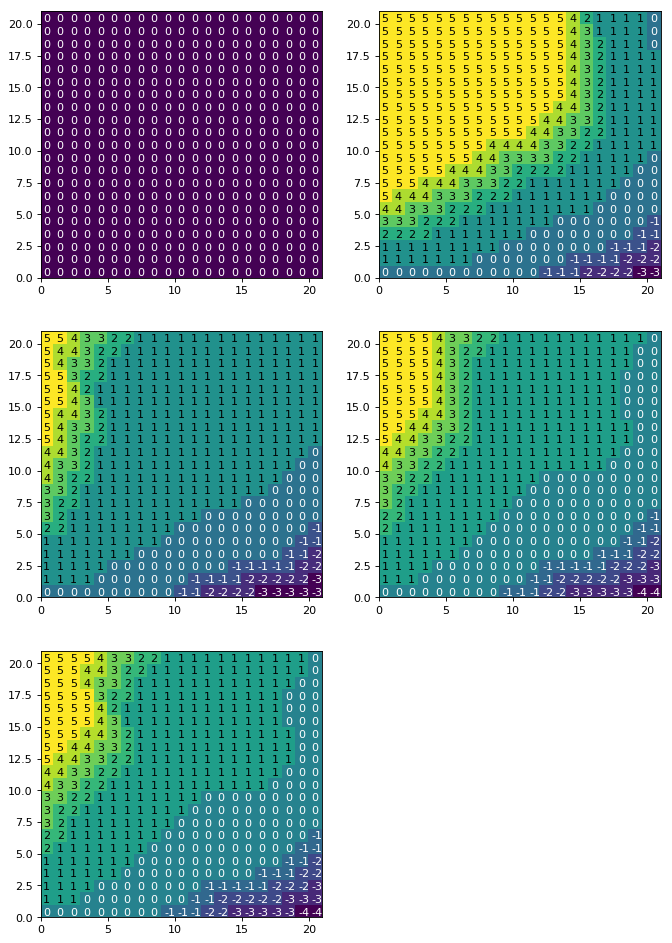

In [106]:
colour_map = [*'w'*6,*'k'*5]
columns = 2
rows = (len(policy_iterations)-1)//2+1
fig = plt.figure(figsize=(5*columns,5*rows), dpi=80)
for en,pol in enumerate(policy_iterations):
    ax = fig.add_subplot(rows,columns,en+1)
    ax.pcolor(X, Y, pol)
    for xy,t in np.ndenumerate(pol):
        ax.text(xy[1]+0.2, xy[0], t, ha='left', va='bottom', color=colour_map[t+maxCarsTransferred])

In [66]:
poissonCache_2 = np.array([[(poisson.pmf(x,expect), poisson.sf(x-1,expect))
                          for x in range(maxNumCounted+1)]
                         for expect in range(expectedReturn2,expectedRent2+1)],
                       dtype=np.float64)

def getJacksCarProbAndReward(available, transition, remained, expectedRent, expectedReturn):
    # remained = available - (rented + transition) + returned 
    # rented = (available  + returned) - (remained + transition)
    # available_before_rent = remained+rented = available-transition+returned <= maxCarsAvail
    # rented <= maxCarsAvail-remained
    # available-(remained+transition) <= rented <= maxCarsAvail-remained
    # returned = remained - available + rented + transition
    # 0 <= returned
    if transition > available: return [(0.0, 0)]
    expectedReturn -= expectedReturn2
    expectedRent -= expectedReturn2
    is_rented_out = remained==0
    max_returned_left = maxCarsAvail-available+transition

    dist = []
    for returned in range(max_returned_left+1):
        rented = (available  + returned) - (remained + transition)
        rentProb = poissonCache_2[expectedRent, rented, int(is_rented_out)]
        is_max_returned = returned == max_returned_left
        returnedProb = poissonCache_2[expectedReturn, returned, int(is_max_returned)]
        dist.append((rentProb*returnedProb, rented*creditRate))
    
    return dist

def getJacksCarProbDist_2(available, transition, expectedRent, expectedReturn):
    dist = np.zeros(shape=(maxCarsAvail+1,2), dtype=np.float64)
    if transition > available:
        return dist
    
    for remained in range(maxCarsAvail+1):
        dist[remained] = np.sum([(p,p*r) 
            for p,r in getJacksCarProbAndReward(available, transition, remained,
                                                expectedRent, expectedReturn)],
                                axis=0)
    
    return dist

In [16]:
def getJacksCarTransitionsDist(cars_left, transfer):
    p_wr_1 = getJacksCarProbDist(cars_left[0], transfer, expectedRent1, expectedReturn1)
    p_wr_2 = getJacksCarProbDist(cars_left[1], -transfer, expectedRent2, expectedReturn2)
    w_reward = np.sum(p_wr_1[:,1]) + np.sum(p_wr_2[:,1]) - transfer_cost*abs(transfer)
    return (w_reward, 
        np.matmul(np.array([p_wr_1[:,0]]).transpose(), np.array([p_wr_2[:,0]]))
           )
        

### Testing and debugging

In [ ]:
test_action = 2
test_state = (3,19)
gamma = 0.9

getCachedDist(test_state,test_action)[1][4], getJacksCarTransitionsDist(test_state,test_action)[1][4]

In [161]:
test_action = 4
test_state = (9,8)


p1 = np.sum(np.array([prob for next_state, prob, reward 
                           in getJacksCarTransitions(test_state,test_action)],
                    dtype = np.float64)
           )

p3 = np.sum(np.array([prob for next_state, prob, reward 
                           in getJacksCarTransitions_3(test_state,test_action)],
                    dtype = np.float64)
           )

p1,p3

(0.9999999999999994, 0.9999999999999994)

In [76]:
test_action = 1
test_state = (4,8)

(getJacksCarProbDist_2(test_state[0], test_action, expectedRent1, expectedReturn1)[10:],
 getJacksCarProbDist(test_state[0], test_action, expectedRent1, expectedReturn1)[10:])

(array([[ 3.11558835e-03,  3.14528421e-02],
        [ 1.04842807e-03,  9.59340601e-03],
        [ 3.19780208e-04,  2.67262659e-03],
        [ 8.90876053e-05,  6.84653549e-04],
        [ 2.28221423e-05,  1.62209080e-04],
        [ 5.40928516e-06,  3.55785268e-05],
        [ 1.20020316e-06,  6.28869168e-06],
        [ 2.92701703e-07, -4.94523910e-06],
        [ 2.92497076e-07, -3.51029810e-05],
        [ 1.19967118e-06, -1.83227290e-04],
        [ 5.40869124e-06, -8.83554147e-04]]),
 array([[3.11558835e-03, 3.14528421e-02],
        [1.04842807e-03, 9.59340606e-03],
        [3.19780202e-04, 2.67262705e-03],
        [8.90875684e-05, 6.84657083e-04],
        [2.28219028e-05, 1.62234324e-04],
        [5.40781079e-06, 3.57482644e-05],
        [1.19160881e-06, 7.36172507e-06],
        [2.45390836e-07, 1.42045197e-06],
        [4.73483992e-08, 2.49994601e-07],
        [8.33315338e-09, 3.23334814e-08],
        [1.07778271e-09, 0.00000000e+00]]))

In [58]:
test_action = -2
test_state = (13,12)
next_state = (14,11)

gamma = 0.9

d1 = getJacksCarProbAndReward(test_state[0], test_action, next_state[0], 
                                  expectedRent1, expectedReturn1)
(np.sum([p for p,r in d1]), 
 getJacksCarProbDist(test_state[0], test_action, expectedRent1, expectedReturn1
                    )[next_state[0]][0])

(0.1549933833264024, 0.1549933833264024)